In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn import model_selection, preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [366]:
class Open_csv:
    
    def __init__(self):
        pass
    
    def open(self,path_to_file):
        data = np.asarray(pd.read_csv(path_to_file, delimiter=",").values)
        return data

In [367]:
open_csv = Open_csv()
# open high low close

In [332]:
def f_1(vector):
    return (vector[2]-vector[3])/(vector[1]+vector[4]) # (high-low)/(open+close)

In [368]:
# garman-klass
def f(vector):
    # vector[1] = open ; vector[2] = high ; vector[3] = low ; vector[4] = close
    return 12*(np.log(vector[2]/vector[3])**2)-(2*np.log(2)-1)*(np.log(vector[4]/vector[1])**2)

In [403]:
# parkinson
def f(vector):
    # vector[1] = open ; vector[2] = high ; vector[3] = low ; vector[4] = close
    return np.log(vector[2]/vector[3])

In [404]:
def compute_function_returns(function,data):
    returns = []
    for i in range(len(data)):
        returns.append(function(data[i]))
    return np.asarray(returns)

In [405]:
stock_list = ["AC.PA", "AI.PA", "AIR.PA", "ATO.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", 
          "BN.PA", "ENGI.PA", "KER.PA", "OR.PA", "LHN.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
          "UG.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "FP.PA", "FR.PA", "VIE.PA", "DG.PA", "VIV.PA"]

In [406]:
stock_returns = []
for stock_name in stock_list:
    stock_returns.append(compute_function_returns(function=f_1,
                                                 data = open_csv.open("data/"+stock_name+".csv")))

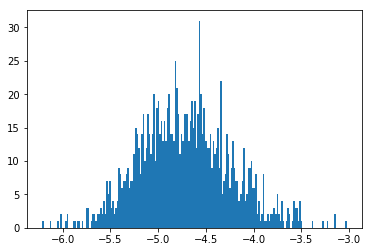

In [407]:
plt.hist(np.log(stock_returns[0]),bins=200)
plt.show()

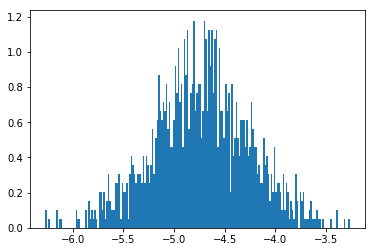

In [408]:
mu = np.mean(np.log(stock_returns[0]))
sigma = np.std(np.log(stock_returns[0]))

s = np.random.normal(mu, sigma, 1300)
plt.hist(s, bins=200, normed=True)
plt.show()

In [409]:
# heavy tail distribution of returns : we take log(returns) instead of returns

In [410]:
log_returns = True

In [411]:
# classification baisse hausse

In [412]:
def classify_vector(vector):
    temp = [-1]*(len(vector)-1)
    for i in range(1,len(vector)):
        if vector[-(i+1)]>=vector[-i]: # hausse
            temp[-i] = 1
    return temp        

In [413]:
# ML for only one stock

In [414]:
index_stock = random.randint(0,len(stock_returns)-1)
returns = stock_returns[index_stock]

if log_returns:
    temp = np.empty(len(np.where(returns!=0)[0]))
    for i in range(len(np.where(returns!=0)[0])):
        temp[i] = returns[np.where(returns!=0)[0][i]]
    returns = np.log(temp)

In [415]:
# depth of learning

In [416]:
depth = 5

In [417]:
X_ = []
y_ = []

for i in range(len(returns)-depth):
    temp = classify_vector(returns)
    y_.append(temp[i])
    X_.append(np.array(temp[i+1:i+1+depth]))
y_ = np.array(y_)

In [418]:
# transform X_ to the required shape for ML algo

In [419]:
test = np.empty((len(X_)-1,len(X_[0])))
for i in range(len(test)):
    test[i] = np.array(X_[i])
X_ = test
y_ = y_[:len(X_)]

In [420]:
def cross_validate(design_matrix, labels, regressor, cv_folds):

    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    for tr, te in cv_folds:        
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr = labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        pred[te] = (regressor.predict(Xte))
        
    return pred

In [421]:
# Set up a stratified 10-fold cross-validation
skf = model_selection.KFold(n_splits=10)
skf.get_n_splits(X_, y_)
folds = [(tr,te) for (tr,te) in skf.split(X_, y_)]

In [422]:
# random forest

In [423]:
optimize_rf = True

In [424]:
if optimize_rf:
    param_grid = {'n_estimators':[1,10],
            'max_features':[1,4],
            'max_depth':[1,9]}

    clf_rf = GridSearchCV(RandomForestClassifier(),
                   param_grid)

    ypred_randomforest = cross_validate(X_, y_, clf_rf, folds)
    
else:
    ypred_randomforest = cross_validate(X_,y_,RandomForestClassifier(),folds)

In [425]:
# svm

In [426]:
optimize_svm = True

In [427]:
if optimize_svm:
    param_grid = {'C':[0.01,10]}

    clf_svm = GridSearchCV(svm.SVC(kernel='linear'),
                   param_grid)

    ypred_svm = cross_validate(X_, y_, clf_svm, folds)

else:
    ypred_svm = cross_validate(X_, y_, svm.SVC(kernel='linear'), folds)

In [428]:
print("mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
print("mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))

mean of |ypred_svm - y_|   :   0.7091194968553459
mean of |ypred_randomforest - y_|   :   0.8034591194968553


In [429]:
# comparaison avec différents prédicteurs "stupides"
y1_ = np.array([-1]*len(y_))
y2_ = np.array([1]*len(y_))
y3_ = np.empty(len(y_))
for i in range(len(y_)):
    y3_[i]=2*random.randint(0,1)-1

print("mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
print("mean of |y2_ - y_|   :   "+str(np.mean(np.abs(y2_-y_))))
print("mean of |y3_ - y_|   :   "+str(np.mean(np.abs(y3_-y_))))

mean of |y1_ - y_|   :   0.9716981132075472
mean of |y2_ - y_|   :   1.028301886792453
mean of |y3_ - y_|   :   0.9575471698113207


In [430]:
# 1ER résultat : notre prédicteur prédit mieux qu'un prédicteur "stupide"

In [431]:
print("accuracy score : "+str(metrics.accuracy_score(y_,y3_)))
print("precision score : "+str(metrics.precision_score(y_,y3_)))
print("recall score : "+str(metrics.recall_score(y_,y3_)))

accuracy score : 0.5212264150943396
precision score : 0.5072
recall score : 0.5129449838187702


In [432]:
# model evaluation for random forest

In [433]:
print("accuracy score : "+str(metrics.accuracy_score(y_,ypred_randomforest)))
print("precision score : "+str(metrics.precision_score(y_,ypred_randomforest)))
print("recall score : "+str(metrics.recall_score(y_,ypred_randomforest)))

accuracy score : 0.5982704402515723
precision score : 0.5914529914529915
recall score : 0.5598705501618123


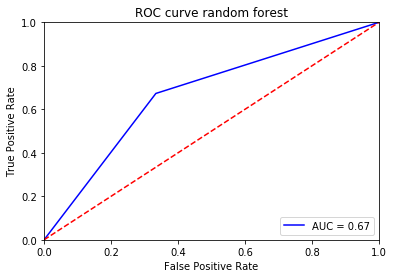

In [434]:
fpr_randomforest, tpr_randomforest, threshold_randomforest = metrics.roc_curve(y_,ypred_randomforest)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve random forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [435]:
# model evaluation for svm

In [436]:
print("accuracy score : "+str(metrics.accuracy_score(y_,ypred_svm)))
print("precision score : "+str(metrics.precision_score(y_,ypred_svm)))
print("recall score : "+str(metrics.recall_score(y_,ypred_svm)))

accuracy score : 0.6454402515723271
precision score : 0.6278713629402757
recall score : 0.6634304207119741


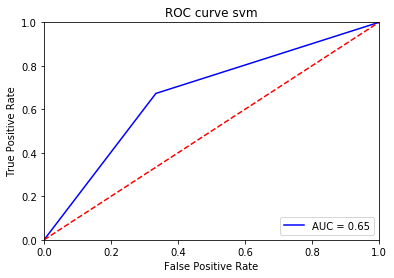

In [437]:
fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_,ypred_svm)
roc_auc = metrics.auc(fpr_svm, tpr_svm)
plt.title('ROC curve svm')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()